# Assignment 1

In [ ]:
import pandas as pd
from datetime import datetime, timedelta

# Define holidays
holidays = {
    "New Year's Day": (1, 1),
    "Memorial Day": "last_monday_of_may",
    "Fourth of July": (7, 4),
    "Labor Day": "first_monday_of_september",
    "Thanksgiving Day": "fourth_thursday_of_november",
    "Christmas Day": (12, 25)
}

# Define valid ISO names
iso_list = ['PJM', 'MISO', 'ERCOT', 'SPP', 'NYISO', 'WECC', 'CAISO'] 

# Define valid peak types
peak_list = ['onpeak', 'offpeak', 'flat', '2x16H', '7x8'] 

# Handle daylight saving time changes: 
# DST begins on the second Sunday in March and ends on the first Sunday in November.
def get_dst_changes(year):
    # Second Sunday in March
    dst_start = min([datetime(year, 3, d) for d in range(8, 15) if datetime(year, 3, d).weekday() == 6])
    # First Sunday in November
    dst_end = min([datetime(year, 11, d) for d in range(1, 8) if datetime(year, 11, d).weekday() == 6])
    return dst_start, dst_end

# Calculate the list of holidays and other days need to exclude when calculating onpeak hours
def get_exclude_dates(year, iso, if_2x16=False):
    exclude_dates = []
    for name, date in holidays.items():
        if isinstance(date, tuple):
            holiday_date = datetime(year, date[0], date[1])
        elif date == "last_monday_of_may":
            holiday_date = max([datetime(year, 5, d) for d in range(25, 32) if datetime(year, 5, d).weekday() == 0])
        elif date == "first_monday_of_september":
            holiday_date = min([datetime(year, 9, d) for d in range(1, 8) if datetime(year, 9, d).weekday() == 0])
        elif date == "fourth_thursday_of_november":
            holiday_date = [datetime(year, 11, d) for d in range(22, 29) if datetime(year, 11, d).weekday() == 3][0]
        exclude_dates.append(holiday_date) # Exclude holidays
        if not if_2x16 and iso == 'MISO':
            # MISO: 'if the holiday occurs on a Sunday, the Monday immediately following the holiday.'
            # This does not apply to 2x16H
            if holiday_date.weekday() == 6:
                exclude_dates.append(holiday_date + timedelta(days=1))
    return exclude_dates

# Parse the input parameter: period
def parse_input(period):
    if "Q" in period:
        year = int(period[:4])
        quarter = int(period[-1])
        start_date = datetime(year, 3 * (quarter - 1) + 1, 1)
        end_date = (start_date + pd.DateOffset(months=3)) - timedelta(days=1)
    elif period.endswith('A'):
        year = int(period[:4])
        start_date = datetime(year, 1, 1)
        end_date = datetime(year, 12, 31)
    elif len(period) == 7 and period[4:].isalpha():
        year = int(period[:4])
        month = datetime.strptime(period[4:], '%b').month
        start_date = datetime(year, month, 1)
        end_date = (start_date + pd.DateOffset(months=1)) - timedelta(days=1)
    elif "-" in period:
        start_date = datetime.strptime(period, "%Y-%m-%d")
        end_date = start_date
    else:
        raise ValueError("Invalid input format")
    
    return start_date, end_date

# Calculate onpeak, offpeak, flat, 2x16H, and 7x8 hours
def calculate_peak_hours(start_date, end_date, iso):
    total_peak_hours, total_offpeak_hours, total_flat_hours, total_2x16_hours, total_7x8_hours = 0, 0, 0, 0, 0
    current_date = start_date
    # exclude_days: calculate onpeak and offpeak hours;
    # Note that MISO excludes the Monday immediately following the holiday;
    # if_2x16: True: not consider the Monday; False: consider the Monday
    exclude_days = get_exclude_dates(start_date.year, iso, if_2x16=False)
    # holidays: calculate 2x16H
    holidays = get_exclude_dates(start_date.year, iso, if_2x16=True)
    dst_start, dst_end = get_dst_changes(start_date.year)
    # Check the peak hours day by day
    while current_date <= end_date:

        # Calculate (1) onpeak and (2) flat; consider DST
        # Calculate (3) offpeak and (4) 7x8; not consider DST
        # Handle CAISO differently when calculating weekdays: 

        # Case 1: workdays
        # CAISO: "Monday through Saturday"; Other ISOs: weekdays
        if current_date not in exclude_days and current_date.weekday() < 6 if iso == 'CAISO' else current_date.weekday() < 5:
            # Handle MISO differently when considering DST:
            if iso == 'MISO': # MISO does not consider DST
                total_peak_hours += 16
                total_offpeak_hours += 8
                total_flat_hours += 24
                total_7x8_hours += 8
            else: # Other ISOs consider DST
                if current_date == dst_start:
                    total_peak_hours += 15  # DST starts: 23-hour day (1 hour lost)
                    total_offpeak_hours += 8
                    total_flat_hours += 23
                    total_7x8_hours += 8
                elif current_date == dst_end:
                    total_peak_hours += 17  # DST ends: 25-hour day (1 extra hour)
                    total_offpeak_hours += 8
                    total_flat_hours += 25
                    total_7x8_hours += 8
                else: # Normal days
                    total_peak_hours += 16
                    total_offpeak_hours += 8
                    total_flat_hours += 24
                    total_7x8_hours += 8
        # Case 2: weekends and holidays
        else:
            if iso == 'MISO': # MISO does not consider DST
                total_offpeak_hours += 24
                total_flat_hours += 24
                total_7x8_hours += 8
            else: # Other ISOs consider DST
                if current_date == dst_start:
                    total_offpeak_hours += 23
                    total_flat_hours += 23
                    total_7x8_hours += 8
                elif current_date == dst_end:
                    total_offpeak_hours += 25
                    total_flat_hours += 25
                    total_7x8_hours += 8
                else: # Normal days
                    total_offpeak_hours += 24
                    total_flat_hours += 24
                    total_7x8_hours += 8
        # Calculate (5) 2x16H; consider DST
        if current_date in holidays or current_date.weekday() >= 5:
            if current_date == dst_start:
                total_2x16_hours += 15  # DST starts: 23-hour day (1 hour lost)

            elif current_date == dst_end:
                total_2x16_hours += 17  # DST ends: 25-hour day (1 extra hour)
            else:
                total_2x16_hours += 16
        current_date += timedelta(days=1)
    
    return total_peak_hours, total_offpeak_hours, total_flat_hours, total_2x16_hours, total_7x8_hours

# Main function
def get_hours(iso, peak_type, period):
    assert iso in iso_list # Check valid input ISO names
    assert peak_type in peak_list # Check valid input peak types
    start_date, end_date = parse_input(period)
    total_peak_hours, total_offpeak_hours, total_flat_hours, total_2x16_hours, total_7x8_hours = calculate_peak_hours(start_date, end_date, iso)
    
    if peak_type == 'onpeak':
        num_hours = total_peak_hours
    elif peak_type == 'offpeak':
        num_hours = total_offpeak_hours
    elif peak_type == 'flat':
        num_hours = total_flat_hours
    elif peak_type == '2x16H':
        num_hours = total_2x16_hours
    elif peak_type == '7x8':
        num_hours = total_7x8_hours

    return {
        'iso': iso.upper(),
        'peak_type' : peak_type.upper(),
        'startdate': start_date.strftime('%Y-%m-%d'),
        'enddate': end_date.strftime('%Y-%m-%d'),
        'num_hours': num_hours
    }    


# Example usage
print(get_hours("MISO", "onpeak", "2018-2-3"))   # Daily
print(get_hours("PJM", "flat", "2018Mar"))    # Monthly
print(get_hours("PJM", "2x16H", "2018Mar"))    # Monthly
print(get_hours("PJM", "7x8", "2018Mar"))    # Monthly
print(get_hours("CAISO", "flat", "2018Mar"))    # Monthly
print(get_hours("CAISO", "offpeak", "2018Q2"))     # Quarterly
print(get_hours("MISO", "onpeak", "2018A"))      # Annually

{'iso': 'MISO', 'peak_type': 'ONPEAK', 'startdate': '2018-02-03', 'enddate': '2018-02-03', 'num_hours': 0}
{'iso': 'PJM', 'peak_type': 'FLAT', 'startdate': '2018-03-01', 'enddate': '2018-03-31', 'num_hours': 743}
{'iso': 'PJM', 'peak_type': '2X16H', 'startdate': '2018-03-01', 'enddate': '2018-03-31', 'num_hours': 143}
{'iso': 'PJM', 'peak_type': '7X8', 'startdate': '2018-03-01', 'enddate': '2018-03-31', 'num_hours': 248}
{'iso': 'CAISO', 'peak_type': 'FLAT', 'startdate': '2018-03-01', 'enddate': '2018-03-31', 'num_hours': 743}
{'iso': 'CAISO', 'peak_type': 'OFFPEAK', 'startdate': '2018-04-01', 'enddate': '2018-06-30', 'num_hours': 952}
{'iso': 'MISO', 'peak_type': 'ONPEAK', 'startdate': '2018-01-01', 'enddate': '2018-12-31', 'num_hours': 4176}


In [ ]:
# emphasize: manual search their website for definition;
# validate based on the online site
#PJM Onpeak(16 hrs): 7 am to 11 pm on Mondays through Fridays, except holidays as defined in the PJM Manuals.
#MISO Onpeak (16 hrs): 6 am to 22 pm weekdays: 16hrs excluding NERC holidays or if the holiday occurs on a Sunday, the Monday immediately following the holiday.
#ERCOT Onpeak (16 hrs): weekdays from ending 7:00 AM to 10:00 PM excluding NERC holidays.
#SPP Onpeak (16 hrs): 6 am to 22 pm excluding Saturdays and Sundays and all NERC holidays
#NYISO Onpeak (16 hrs): 7:00 am to 11:00 pm Monday through Friday, except for NERC-defined holidays
#WECC Onpeak (16 hrs): 6:00 a.m. to 10:00 p.m. CDT on weekdays, excluding NERC holidays
#CAISO Onpeak(16 hrs): Monday through Saturday, 6:00 AM–22:00 PM, Pacific Prevailing Time (PPT), excluding NERC Holidays

# Assignment 2

## I. Merging data

In [ ]:
import pandas as pd
import numpy as np
import re
from datetime import datetime, timedelta


def detect_and_normalize_timestamp(text):
    # Define regex patterns for the three timestamp formats
    patterns = {
        'month/day/year': r'\b(0?[1-9]|1[0-2])/(0?[1-9]|[12][0-9]|3[01])/(?:\d{2,4})\b',
        'month/day': r'\b(0?[1-9]|1[0-2])/(0?[1-9]|[12][0-9]|3[01])\b',
        'hour:minute:second': r'\b(0?[0-9]|1[0-9]|2[0-3]):[0-5][0-9]:[0-5][0-9]\b',
        'hour:minute': r'\b(0?[0-9]|1[0-9]|2[0-3]):[0-5][0-9]\b'
    }
    
    date_pattern = patterns['month/day/year']
    date_pattern1 = patterns['month/day']
    time_pattern_with_seconds = patterns['hour:minute:second']
    time_pattern_without_seconds = patterns['hour:minute']
    
    # Search for the date pattern in the text
    date_match = re.search(date_pattern, text)
    date_match1 = re.search(date_pattern1, text) 
    if date_match:
        date = date_match.group()
        month, day, _ = date.split('/')
    elif date_match1:
        date = date_match1.group()
        month, day = date.split('/')
    else:
        return False
    
    # Search for the time pattern with seconds in the text
    time_match_with_seconds = re.search(time_pattern_with_seconds, text)
    if time_match_with_seconds:
        time = time_match_with_seconds.group()
    else:
        # If no match, search for the time pattern without seconds
        time_match_without_seconds = re.search(time_pattern_without_seconds, text)
        if time_match_without_seconds:
            time = time_match_without_seconds.group() + ':00'
        else:
            return False
    
    # Construct the normalized timestamp
    normalized_timestamp = f'{2013}/{month}/{day} {time}'
    return normalized_timestamp

def find_and_normalize_timestamp_column(df):
    for column in df.columns:
        # Try to find a timestamp in the first few rows of the column
        for value in df[column].dropna().astype(str).head(10):
            normalized_value = detect_and_normalize_timestamp(value)
            if normalized_value:
                # If a timestamp is found, normalize the entire column
                df[column] = df[column].astype(str).apply(detect_and_normalize_timestamp)
                df[column] = pd.to_datetime(df[column], format='%Y/%m/%d %H:%M:%S', errors='raise')
                return df.columns.get_loc(column), df
    return None, df

def detect_index_column(df):
    # Check for columns with unique sequential numbers
    for column in df.columns:
        if pd.api.types.is_numeric_dtype(df[column]):
            if df[column].is_monotonic_increasing and df[column].nunique() == len(df):
                return df.columns.get_loc(column)
    
    # If no index column is detected
    return None

def parse_df(df):
    idx_col = detect_index_column(df)
    if idx_col != None:
        df = df.drop(columns=[df.columns[idx_col]])
    time_col, df = find_and_normalize_timestamp_column(df)
    exclude_columns = [idx_col, time_col]
    return df, time_col, [col for col in list(range(len(df.columns))) if col not in exclude_columns]

def resample_and_merge(hourly_data, idx1, minute_data, idx2):
    time_col_name1, time_col_name2 = hourly_data.columns[idx1[0]], minute_data.columns[idx2[0]]
    minute_data[time_col_name2] = pd.to_datetime(minute_data[time_col_name2])
    # Set 'time' as the index
    minute_data.set_index(time_col_name2, inplace=True)

    # Convert the 'Date/Time' column in hourly_data to datetime format
    hourly_data[time_col_name1] = pd.to_datetime(hourly_data[time_col_name1])

    # Set 'Date/Time' as the index
    hourly_data.set_index(time_col_name1, inplace=True)

    # Resample minute_data to hourly data
    minute_data_resampled = minute_data.resample('H').sum()
    
    # Merge the two DataFrames on their indexes
    merged_data = hourly_data.join(minute_data_resampled, how='inner')    

    # Rename columns for clarity
    merged_data.rename(columns={merged_data.columns[-1]: 'New_Appliance_Consumption_KW'}, inplace=True)
    merged_data['New_Appliance_Consumption_KW'] = merged_data['New_Appliance_Consumption_KW'] / 1000

    # Calculate total hourly consumption
    merged_data['Total_Hourly_Consumption_kW'] = merged_data.sum(axis=1)
    
    return merged_data

hourly_data = pd.read_csv('/work/Assignment 2 - USA_AL_Auburn-Opelika.AP.722284_TMY3_BASE.csv')
minute_data = pd.read_csv('/work/Assignment 2 - new.app4.csv')
hourly_data, time_col1, content_cols1 = parse_df(hourly_data)
minute_data, time_col2, content_cols2 = parse_df(minute_data)
merged_data = resample_and_merge(hourly_data, [time_col1, content_cols1], minute_data, [time_col2, content_cols2])
merged_data.head()



,Electricity:Facility [kW](Hourly),Gas:Facility [kW](Hourly),Heating:Electricity [kW](Hourly),Heating:Gas [kW](Hourly),Cooling:Electricity [kW](Hourly),HVACFan:Fans:Electricity [kW](Hourly),Electricity:HVAC [kW](Hourly),Fans:Electricity [kW](Hourly),General:InteriorLights:Electricity [kW](Hourly),General:ExteriorLights:Electricity [kW](Hourly),Appl:InteriorEquipment:Electricity [kW](Hourly),Misc:InteriorEquipment:Electricity [kW](Hourly),Water Heater:WaterSystems:Electricity [kW](Hourly),New_Appliance_Consumption_KW,Total_Hourly_Consumption_kW
2013-06-07 11:00:00,1.479426,0.018757,0.0,0.0,0.347519,0.100007,0.447526,0.100007,0.047163,0.010160,0.360615,0.272322,0.324996,57.388943,60.897441
2013-06-07 12:00:00,1.559733,0.018441,0.0,0.0,0.454263,0.130764,0.585027,0.130764,0.047163,0.010160,0.350008,0.267735,0.282996,27.227961,31.065016
2013-06-07 13:00:00,1.702835,0.019079,0.0,0.0,0.603876,0.169912,0.773789,0.169912,0.047163,0.010160,0.319024,0.276993,0.259063,111.476298,115.828105
2013-06-07 14:00:00,1.859094,0.020153,0.0,0.0,0.752179,0.211629,0.963808,0.211629,0.047163,0.010160,0.294229,0.292590,0.234500,109.021960,113.919095
2013-06-07 15:00:00,2.100629,0.021274,0.0,0.0,0.921579,0.253177,1.174756,0.253177,0.050307,0.010837,0.301026,0.308854,0.238204,5.773963,11.407785


## II. Visualization

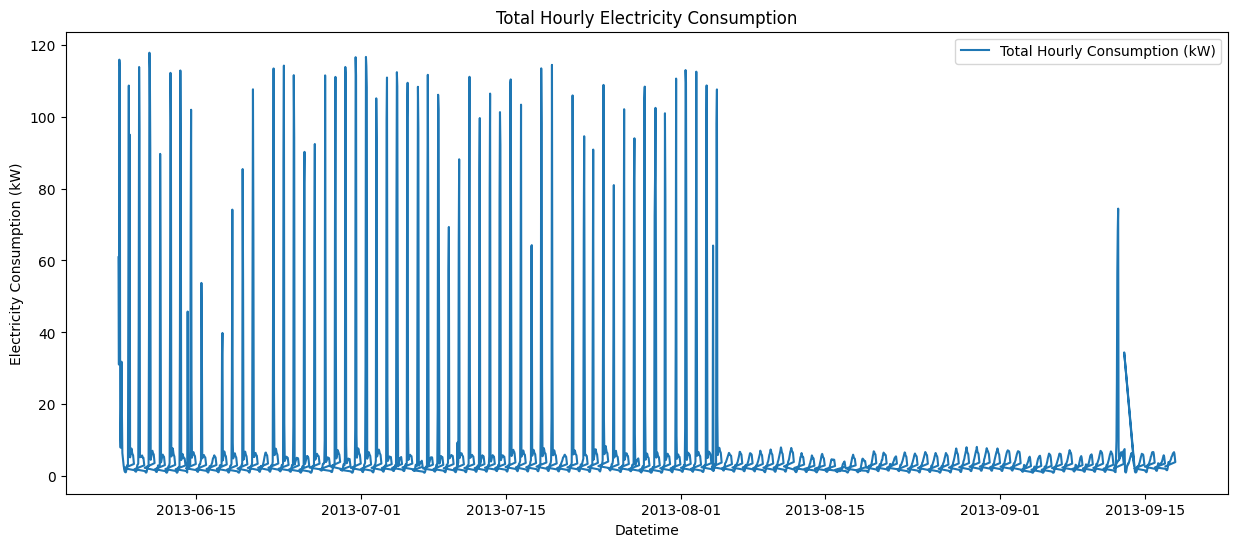

/tmp/ipykernel_81/797576221.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weekday_avg = merged_data.groupby('Weekday')['Total_Hourly_Consumption_kW'].mean()


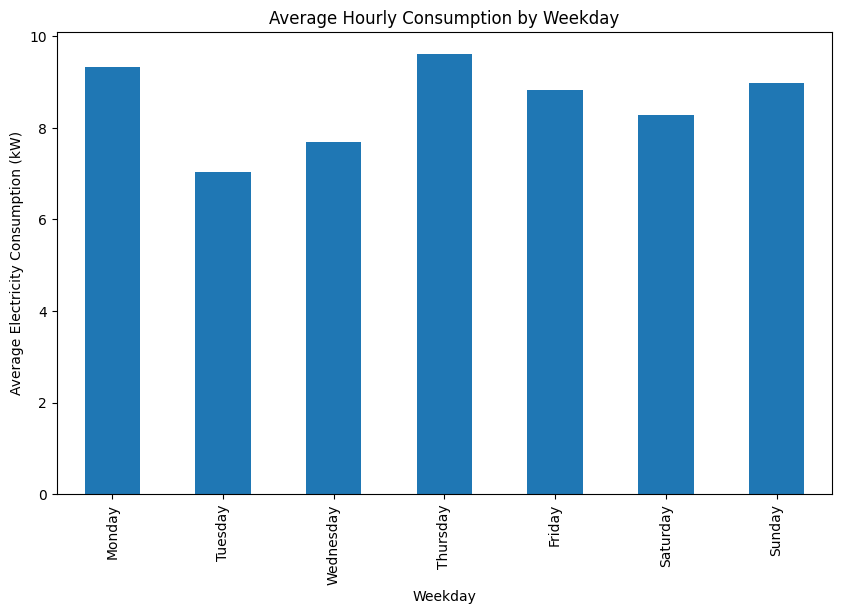

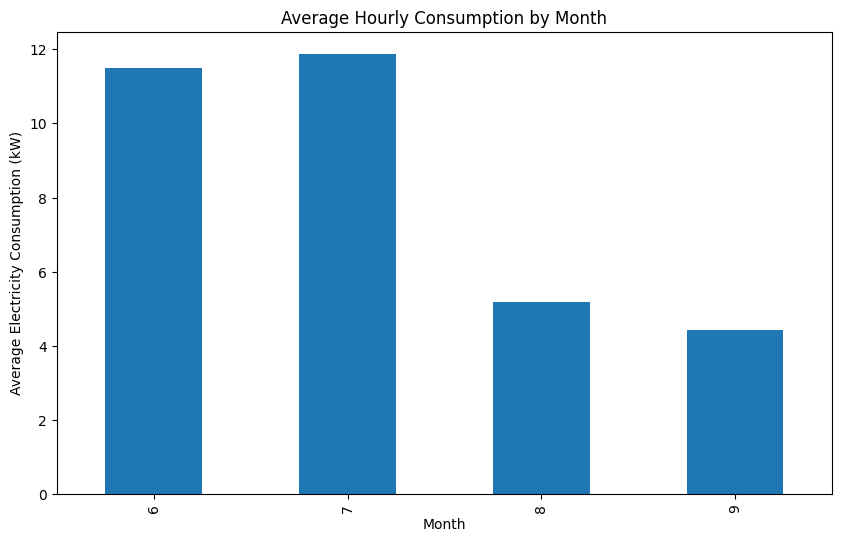

In [ ]:
# Plotting the data
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(merged_data.index, merged_data['Total_Hourly_Consumption_kW'], label='Total Hourly Consumption (kW)')
plt.title('Total Hourly Electricity Consumption')
plt.xlabel('Datetime')
plt.ylabel('Electricity Consumption (kW)')
plt.legend()
plt.show()

# Additional analysis
merged_data['Weekday'] = merged_data.index.weekday
weekday_names = {0: 'Monday',1: 'Tuesday',2: 'Wednesday',3: 'Thursday',4: 'Friday',5: 'Saturday',6: 'Sunday'}
# Replace integer values in 'Weekday' column with corresponding weekday names
merged_data['Weekday'] = merged_data['Weekday'].map(weekday_names)
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
merged_data['Weekday'] = pd.Categorical(merged_data['Weekday'], categories=weekday_order, ordered=True)

merged_data['Month'] = merged_data.index.month

# Plot consumption by weekday
plt.figure(figsize=(10, 6))
weekday_avg = merged_data.groupby('Weekday')['Total_Hourly_Consumption_kW'].mean()
weekday_avg.plot(kind='bar')
plt.title('Average Hourly Consumption by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Average Electricity Consumption (kW)')
plt.show()

# Plot consumption by month
plt.figure(figsize=(10, 6))
monthly_avg = merged_data.groupby('Month')['Total_Hourly_Consumption_kW'].mean()
monthly_avg.plot(kind='bar')
plt.title('Average Hourly Consumption by Month')
plt.xlabel('Month')
plt.ylabel('Average Electricity Consumption (kW)')
plt.show()

# Assignment 3

## I. EDA

                            DATETIME  HB_NORTH (RTLMP)  ERCOT (WIND_RTI)  \
count                          14987      14987.000000      14982.000000   
mean   2017-11-09 06:41:09.340094720         25.766417       7532.436283   
min              2017-01-01 01:00:00        -17.860000         54.440000   
25%              2017-06-06 04:30:00         18.041250       4135.630000   
50%              2017-11-09 06:00:00         20.057500       7281.445000   
75%              2018-04-14 09:30:00         25.030000      10851.647500   
max              2018-09-17 12:00:00       2809.357500      20350.400000   
std                              NaN         46.361945       3992.884834   

       ERCOT (GENERATION_SOLAR_RT)  ERCOT (RTLOAD)    HOURENDING  \
count                 14983.000000    14987.000000  14987.000000   
mean                    291.989714    42371.673703     12.495763   
min                       0.000000    25566.511248      1.000000   
25%                       0.000000    35431

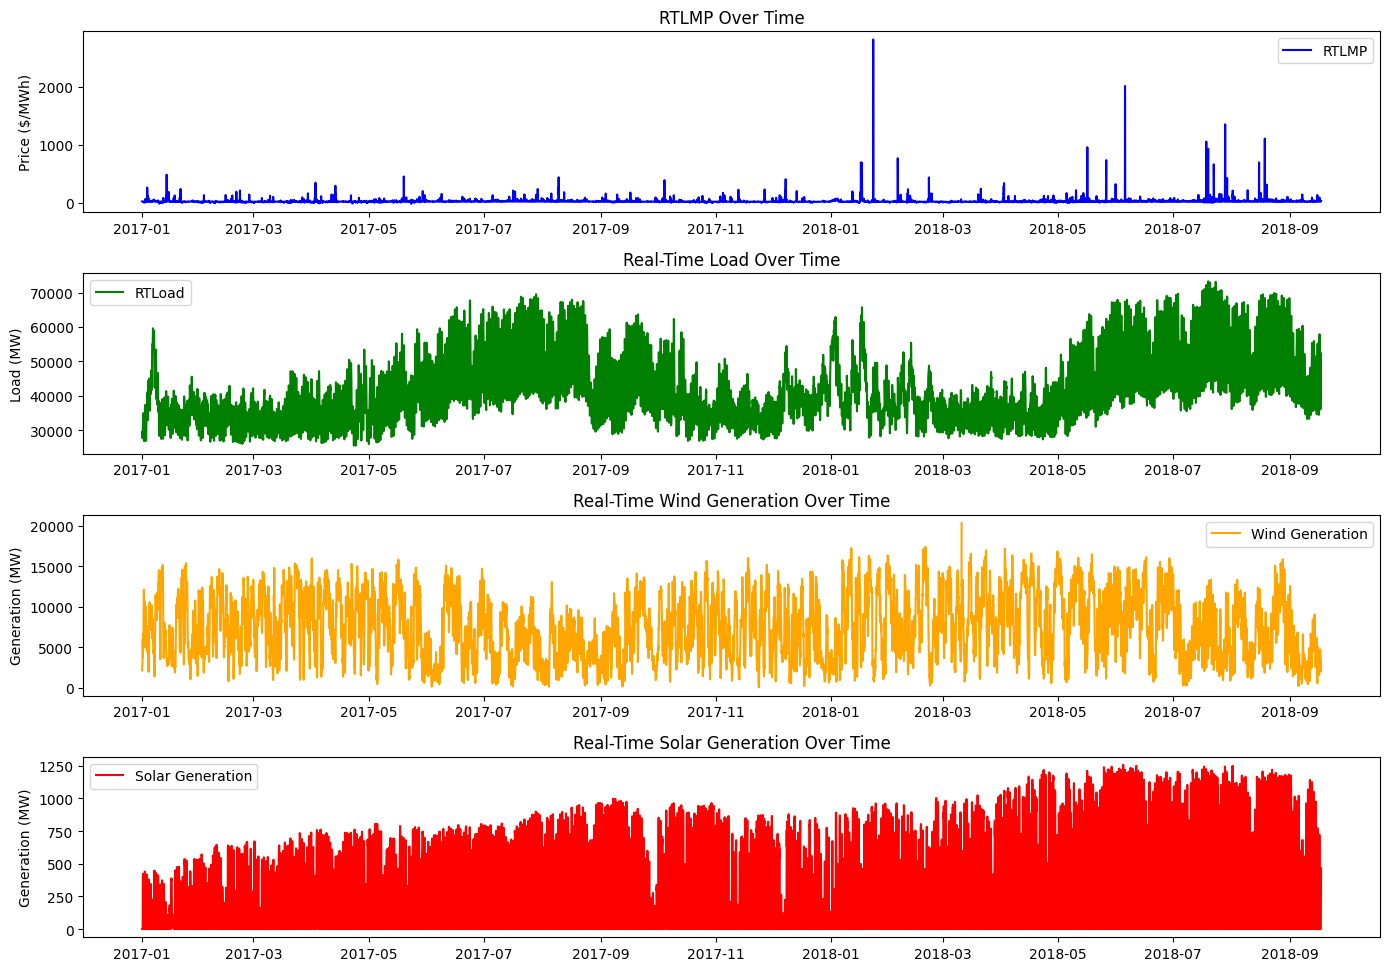

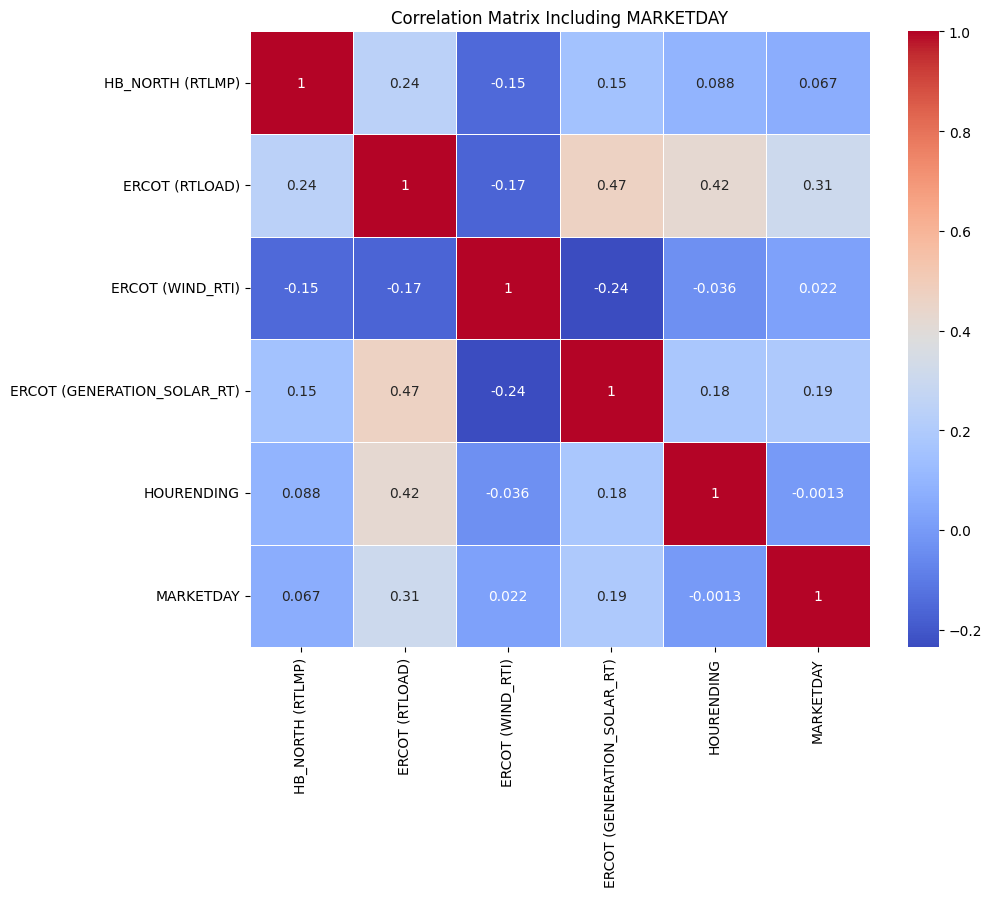

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
file_path = '/work/Assignment 3 - timeseries_data.xlsx'
timeseries_data = pd.read_excel(file_path)

# Convert the timestamp to datetime format
timeseries_data['timestamp'] = pd.to_datetime(timeseries_data['DATETIME'])

# Set timestamp as the index
timeseries_data.set_index('timestamp', inplace=True)

# Display the first few rows of the dataframe
timeseries_data.head()

# Summary statistics
summary_stats = timeseries_data.describe()
print(summary_stats)

# Plotting the time series data
plt.figure(figsize=(14, 12))

# Plot RTLMP
plt.subplot(5, 1, 1)
plt.plot(timeseries_data['HB_NORTH (RTLMP)'], label='RTLMP', color='blue')
plt.title('RTLMP Over Time')
plt.ylabel('Price ($/MWh)')
plt.legend()

# Plot RTLoad
plt.subplot(5, 1, 2)
plt.plot(timeseries_data['ERCOT (RTLOAD)'], label='RTLoad', color='green')
plt.title('Real-Time Load Over Time')
plt.ylabel('Load (MW)')
plt.legend()

# Plot WIND_RTI
plt.subplot(5, 1, 3)
plt.plot(timeseries_data['ERCOT (WIND_RTI)'], label='Wind Generation', color='orange')
plt.title('Real-Time Wind Generation Over Time')
plt.ylabel('Generation (MW)')
plt.legend()

# Plot GENERATION_SOLAR_RT
plt.subplot(5, 1, 4)
plt.plot(timeseries_data['ERCOT (GENERATION_SOLAR_RT)'], label='Solar Generation', color='red')
plt.title('Real-Time Solar Generation Over Time')
plt.ylabel('Generation (MW)')
plt.legend()

plt.tight_layout()
plt.show()

# Correlation matrix for numerical columns
numerical_columns = ['HB_NORTH (RTLMP)', 'ERCOT (RTLOAD)', 'ERCOT (WIND_RTI)', 'ERCOT (GENERATION_SOLAR_RT)', 'HOURENDING']
correlation_matrix = timeseries_data[numerical_columns].corr()

# Encoding MARKETDAY as a categorical variable
timeseries_data['MARKETDAY'] = timeseries_data['MARKETDAY'].astype('category').cat.codes

# Correlation including MARKETDAY
all_columns = numerical_columns + ['MARKETDAY']
correlation_matrix_with_marketday = timeseries_data[all_columns].corr()

# Plotting the correlation matrix with MARKETDAY
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_with_marketday, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Including MARKETDAY')
plt.savefig('corr')

plt.show()


## II. ARMAV Modeling

Augmented Dickey-Fuller Test: HB_NORTH (RTLMP)
ADF Test Statistic            -1.829790e+01
p-value                        2.289911e-30
# Lags Used                    2.400000e+01
Number of Observations Used    1.496200e+04
Critical Value (1%)           -3.430787e+00
Critical Value (5%)           -2.861733e+00
Critical Value (10%)          -2.566873e+00

Augmented Dickey-Fuller Test: ERCOT (RTLOAD)
ADF Test Statistic                -5.064009
p-value                            0.000017
# Lags Used                       42.000000
Number of Observations Used    14944.000000
Critical Value (1%)               -3.430788
Critical Value (5%)               -2.861733
Critical Value (10%)              -2.566873

Augmented Dickey-Fuller Test: ERCOT (WIND_RTI)
ADF Test Statistic            -1.140863e+01
p-value                        7.343503e-21
# Lags Used                    4.200000e+01
Number of Observations Used    1.493900e+04
Critical Value (1%)           -3.430788e+00
Critical Value (5%)    

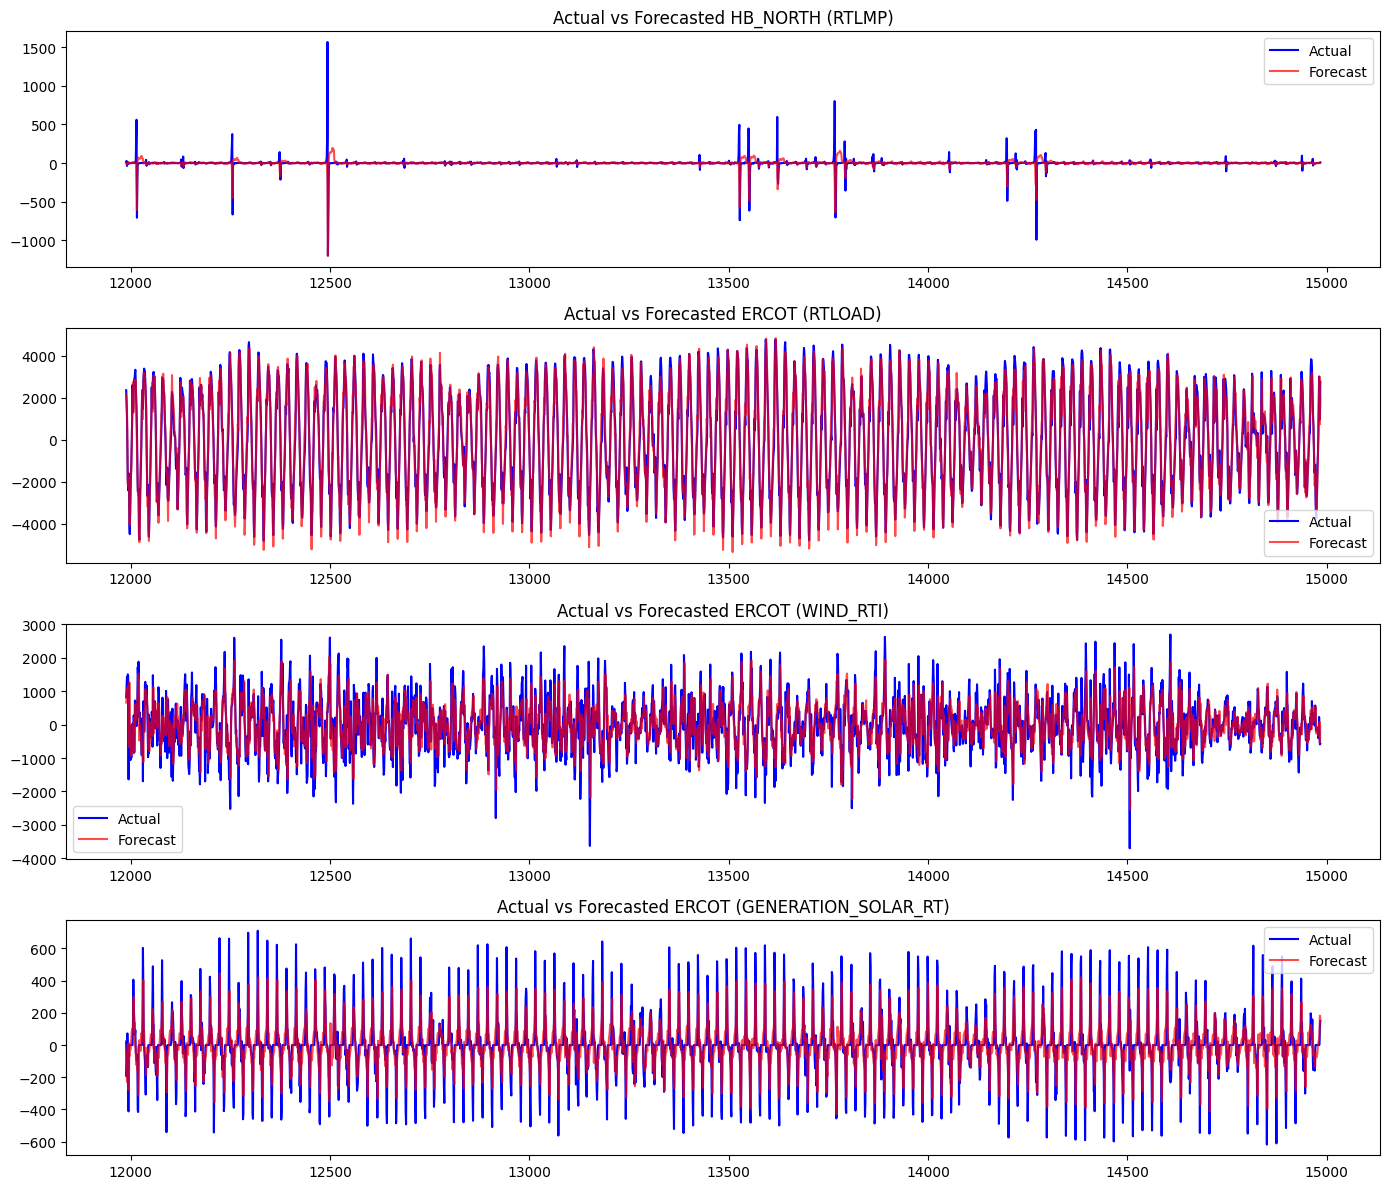

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

file_path = '/work/Assignment 3 - timeseries_data.xlsx'
timeseries_data = pd.read_excel(file_path)

# Selecting the required columns
data = timeseries_data[['HB_NORTH (RTLMP)', 'ERCOT (RTLOAD)', 'ERCOT (WIND_RTI)', 'ERCOT (GENERATION_SOLAR_RT)']]

# Checking for stationarity
def adf_test(series, title=''):
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Test Statistic', 'p-value', '# Lags Used', 'Number of Observations Used']
    out = pd.Series(result[0:4], index=labels)
    for key, val in result[4].items():
        out[f'Critical Value ({key})'] = val
    print(f'Augmented Dickey-Fuller Test: {title}')
    print(out.to_string())
    print('')

# Perform ADF test for each column
for column in data.columns:
    adf_test(data[column], title=column)

# Differencing the data to make it stationary
data_diff = data.diff().dropna()

# Train-test split
train_data = data_diff[:int(0.8*len(data_diff))]
test_data = data_diff[int(0.8*len(data_diff)):]

# One-step ahead forecasting
model = VAR(train_data)
fitted_model = model.fit(maxlags=15, ic='aic')

history = train_data.values.tolist()
predictions = []


for i in range(len(test_data)):
    model = VAR(pd.DataFrame(history))
    fitted_model = model.fit(maxlags=15, ic='aic')
    yhat = fitted_model.forecast(fitted_model.endog[-fitted_model.k_ar:], steps=1)
    predictions.append(yhat[0])
    history.append(test_data.values[i])

# Convert predictions to DataFrame
predictions_df = pd.DataFrame(predictions, index=test_data.index, columns=test_data.columns)

# Evaluate the model
for col in train_data.columns:
    mse = mean_squared_error(test_data[col], predictions_df[col])
    print(f'Mean Squared Error for {col}: {mse}')

# Plot the actual vs predicted values
plt.figure(figsize=(14, 12))

for i, col in enumerate(train_data.columns):
    plt.subplot(4, 1, i+1)
    plt.plot(test_data[col], label='Actual', color='blue')
    plt.plot(predictions_df[col], label='Forecast', color='red', alpha=0.7)
    plt.title(f'Actual vs Forecasted {col}')
    plt.legend()

plt.tight_layout()
plt.show()


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=aa28d668-0952-4588-b8ca-2e4250f2d98a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>